In [48]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [49]:
mp_holistic = mp.solutions.holistic #holistic model
mp_drawing = mp.solutions.drawing_utils # drawing utilities

<h3> preprocess Data and create Label and features </h3>

In [50]:
actions = np.array(['hello', 'thanks','good','seeyoulater', 'ithink', 'youarepretty', 'iloveyou', 'cute'])
# actions = np.array(['hello', 'good','iloveyou'])
no_sequences = 30
sequence_length = 30
DATA_PATH = os.path.join('MP_Data')
label_map = {label:num for num, label in enumerate(actions)}

In [51]:
sequences,labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH,action,str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [52]:
label_map

{'hello': 0,
 'thanks': 1,
 'good': 2,
 'seeyoulater': 3,
 'ithink': 4,
 'youarepretty': 5,
 'iloveyou': 6,
 'cute': 7}

In [53]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X.shape, y.shape

((240, 30, 1662), (240, 8))

In [54]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp,random_state=42)

In [55]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((192, 30, 1662), (24, 30, 1662), (24, 30, 1662), (192, 8), (24, 8), (24, 8))

In [56]:
actions.shape[0]

8

In [57]:
frame = np.array(sequences).shape[1]
keypoint = np.array(sequences).shape[2]
print(frame, keypoint)


30 1662


In [58]:
model = Sequential()
model.add(LSTM(64, input_shape=(frame, keypoint), return_sequences=True, activation='relu'))
# model.add(Dropout(0.1))
model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))


In [59]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [60]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='categorical_accuracy')

history = model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=1000,
          callbacks=[
            #   ModelCheckpoint('models.h5', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='auto'), 
            # use the code below to save list of models
              ModelCheckpoint('models_normalwithmax/model-{epoch:02d}-{val_loss:.2f}-{val_categorical_accuracy:.2f}.h5', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='auto'), 
              # ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.3, patience=100, verbose=1, mode='auto'),
              EarlyStopping(monitor='val_loss', mode="max",patience=200, verbose=1)
              ])

Epoch 1/1000
6/6 [==============================] - ETA: 0s - loss: 19.2569 - categorical_accuracy: 0.1146
Epoch 1: val_categorical_accuracy improved from -inf to 0.08333, saving model to models_normalwithmax\model-01-13.71-0.08.h5
6/6 [==============================] - 4s 194ms/step - loss: 19.2569 - categorical_accuracy: 0.1146 - val_loss: 13.7078 - val_categorical_accuracy: 0.0833
Epoch 2/1000
2/6 [=========>....................] - ETA: 0s - loss: 22.7126 - categorical_accuracy: 0.1094

c:\Users\Zero\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - ETA: 0s - loss: 19.2627 - categorical_accuracy: 0.1719
Epoch 2: val_categorical_accuracy did not improve from 0.08333
6/6 [==============================] - 0s 83ms/step - loss: 19.2627 - categorical_accuracy: 0.1719 - val_loss: 40.5965 - val_categorical_accuracy: 0.0417
Epoch 3/1000
6/6 [==============================] - ETA: 0s - loss: 26.4545 - categorical_accuracy: 0.1354
Epoch 3: val_categorical_accuracy did not improve from 0.08333
6/6 [==============================] - 0s 86ms/step - loss: 26.4545 - categorical_accuracy: 0.1354 - val_loss: 11.9941 - val_categorical_accuracy: 0.0417
Epoch 4/1000
6/6 [==============================] - ETA: 0s - loss: 17.2241 - categorical_accuracy: 0.1354
Epoch 4: val_categorical_accuracy did not improve from 0.08333
6/6 [==============================] - 0s 82ms/step - loss: 17.2241 - categorical_accuracy: 0.1354 - val_loss: 9.4171 - val_categorical_accuracy: 0.0833
Epoch 5/1000
6/6 [========================

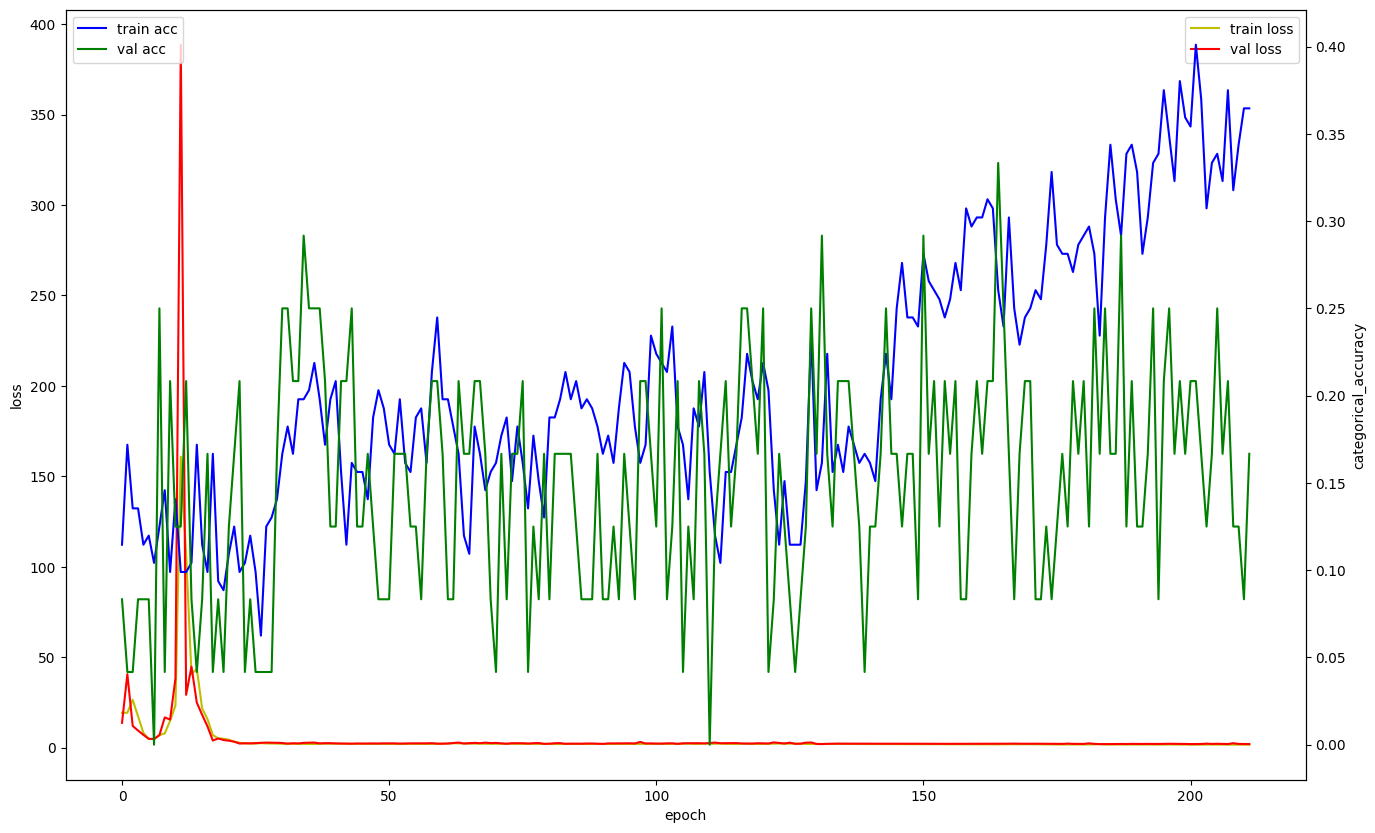

In [61]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc=('upper right'))

acc_ax.plot(history.history['categorical_accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_categorical_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('categorical_accuracy')
acc_ax.legend(loc='upper left')

plt.show()

<h3> Plot Confusion Matrix</h3>

In [45]:
del model 
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
#False because next layer is Dense layer
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='categorical_accuracy')
model.load_weights("models_normalwithmax\model-44-0.15-0.96.h5")

# model.save('action.h5')

# model.load_weights('action.h5')

In [46]:
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
y_hat = model.predict(X_test)
y_true = np.argmax(y_test, axis=1).tolist()
y_hat = np.argmax(y_hat, axis=1).tolist()
multilabel_confusion_matrix(y_true, y_hat)

1/1 [==============================] - 0s 499ms/step


array([[[20,  1],
        [ 0,  3]],

       [[20,  1],
        [ 1,  2]],

       [[21,  0],
        [ 0,  3]],

       [[21,  0],
        [ 2,  1]],

       [[21,  0],
        [ 0,  3]],

       [[21,  0],
        [ 0,  3]],

       [[21,  0],
        [ 1,  2]],

       [[19,  2],
        [ 0,  3]]], dtype=int64)

In [47]:
accuracy_score(y_true, y_hat)


0.8333333333333334

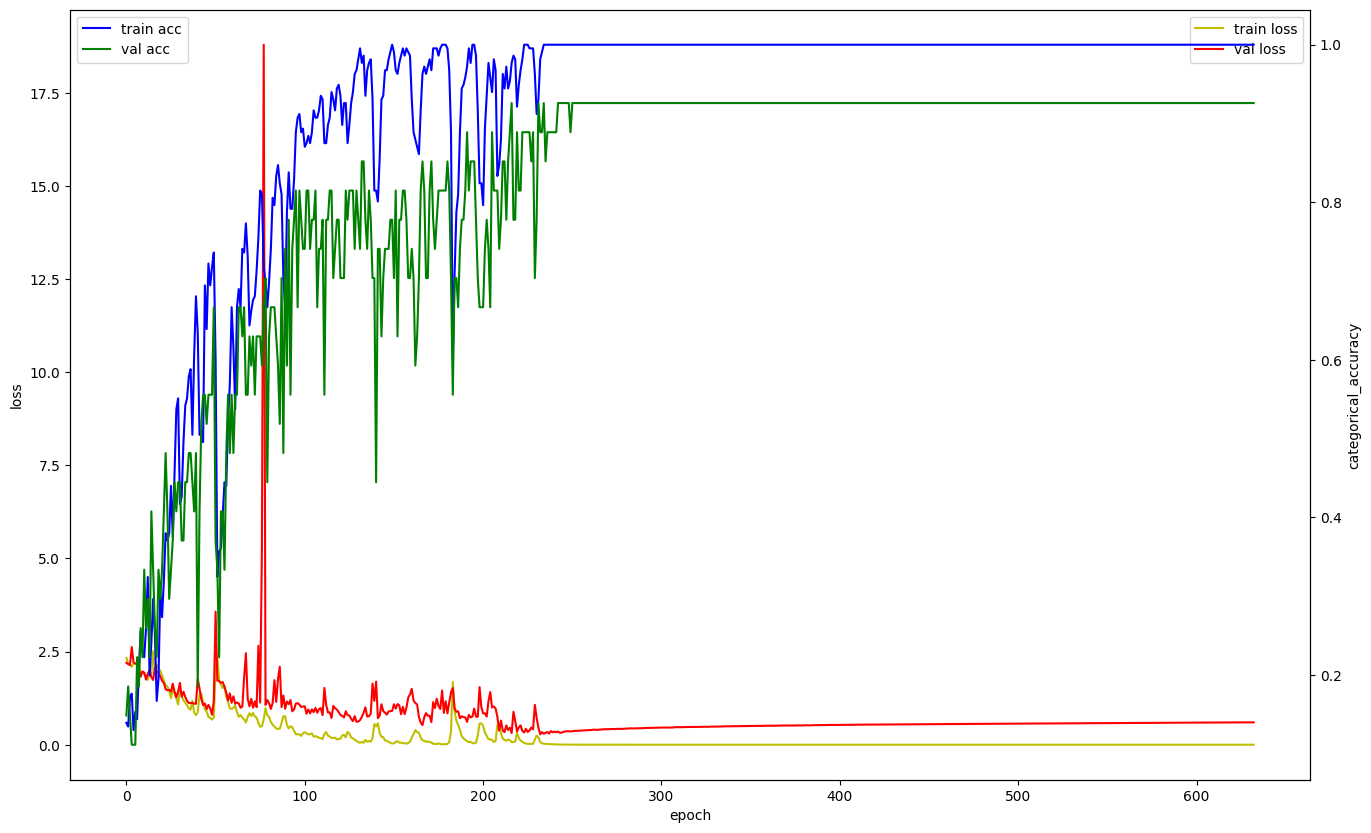

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc=('upper right'))

acc_ax.plot(history.history['categorical_accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_categorical_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('categorical_accuracy')
acc_ax.legend(loc='upper left')

plt.show()